In [15]:
from Systems import UnbalancedDisc
from Systems import NoisyUnbalancedDisc
from Systems import OutputUnbalancedDisc
import deepSI
from matplotlib import pyplot as plt
import numpy as np

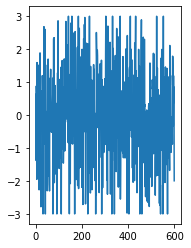

In [18]:
#out = np.load('measurement-datasets/disk-measurement-dataset-1.npz') 
#u1 = out['u'] #inputs
#th = out['th'] #outputs
#t = out['t'] #time vector

u = deepSI.deepSI.exp_design.multisine(100000, pmax=49999, n_crest_factor_optim=20)#49999
u = np.clip(u*1.5, -3, 3)
plt.subplot(1,2,1)
plt.plot(u[:600])
# plt.subplot(1,2,2)
# plt.plot(u1[:300])

In [133]:
u = 1*deepSI.deepSI.exp_design.multisine(500, pmax=50, n_crest_factor_optim=20)
system = OutputUnbalancedDisc(dt=0.1, sigma_n=[0.015])
#system_discrete = DiscreteUnbalancedDisc(dt=0.1)
data = system.apply_experiment(deepSI.System_data(u=u))
#data_discrete = system_discrete.apply_experiment(deepSI.System_data(u=u))
#data = system_discrete.apply_experiment(deepSI.System_data(u=u))

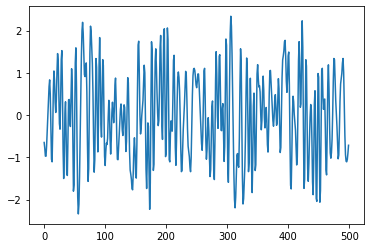

In [134]:
plt.plot(u[:500])

In [135]:
def stackReferences(references_tuple):
    return np.vstack(references_tuple)

In [136]:
yref = data.y[:500,0]
yref.shape
x_reference_list = stackReferences((np.zeros((500)), yref))

In [137]:
x_reference_list.shape

(2, 500)

In [138]:
np.save("references/multiSineInOutNsim500.npy", x_reference_list)

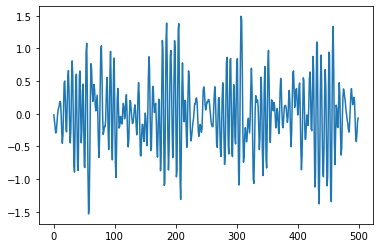

In [139]:
# plt.subplot(1,2,1)
# plt.plot(data.y[:,0])
# plt.subplot(1,2,2)
# plt.plot(data.y[:,1])
plt.plot(data.y[:500])

In [5]:
Spower = np.sum(np.square(data.y), axis=0)/data.y.shape[0]
Spower

array([0.22527893])

In [14]:
#Npower = np.sum(np.square(np.hstack((np.random.normal(0, 0.47, (10000,1)), np.random.normal(0, 0.044, (10000,1))))), axis=0)/10000
Npower = np.sum(np.square(np.random.normal(0, 0.045, (10000,1))), axis=0)/10000
# SNR 200 = [0.33, 0.032]
# SNR 100 = [0.47, 0.044]
# SNR 50 = [0.48, 0.044]
# SNR 20 = [0.77, 0.074]
# SNR 10 = [1.45 0.14]
# SNR 5.2 = [2.3 0.22]
10*np.log10(Spower / Npower)

array([20.44506107])

In [ ]:
from torch import nn
class I_encoder(deepSI.fit_systems.SS_encoder):
    def __init__(self, nx = 2, na=2, nb=2, feedthrough=False) -> None:
        super().__init__(nx=nx, na=na, nb=nb, feedthrough=feedthrough)
        #self.f_n_nodes_per_layer = 32

    def init_nets(self, nu, ny): # a bit weird
        ny = ny if ny is not None else 1
        nu = nu if nu is not None else 1
        self.encoder = self.e_net(self.nb*nu+self.na*ny, self.nx, n_nodes_per_layer=self.e_n_nodes_per_layer, n_hidden_layers=self.e_n_hidden_layers, activation=self.e_activation)
        self.fn =      self.f_net(self.nx+nu,            self.nx, n_nodes_per_layer=self.f_n_nodes_per_layer, n_hidden_layers=self.f_n_hidden_layers, activation=self.f_activation)
        hn_in = self.nx + nu if self.feedthrough else self.nx
        #self.hn =      stateSelector()
        self.hn =      nn.Identity(hn_in)#self.h_net(hn_in     ,            ny,      n_nodes_per_layer=self.h_n_nodes_per_layer, n_hidden_layers=self.h_n_hidden_layers, activation=self.h_activation)

In [35]:
# I_enc = I_encoder(nx=2, na=2, nb=2, feedthrough=False)
# I_enc.f_n_nodes_per_layer
#I_enc = deepSI.fit_systems.SS_encoder(nx=2, na=2, nb=2, feedthrough=False)
I_enc = deepSI.fit_systems.SS_encoder_general(nx=2, na=4, nb=4, na_right=1)
# I_enc.unique_code = 'sEIUSw'
# I_enc.checkpoint_load_system('_best')

In [36]:
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

In [44]:
I_enc.fit(train_sys_data=train, val_sys_data=val, epochs=30, batch_size=256, loss_kwargs={'nf':150})
#I_enc.fit(train_sys_data=train, val_sys_data=val, epochs=100, batch_size=256, loss_kwargs={'nf':150})

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  141.1 MB
N_training_samples = 59847, batch_size = 256, N_batch_updates_per_epoch = 233
Initial Validation sim-NRMS= 0.14983741204783213


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch    1, sqrt loss 0.05673, Val sim-NRMS 0.08102, Time Loss: 93.7%, data: 0.1%, val: 6.2%,  3.2 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.04170062021474476
Epoch    2, sqrt loss 0.05676, Val sim-NRMS 0.0417, Time Loss: 93.4%, data: 0.1%, val: 6.5%,  3.2 batches/sec
Epoch    3, sqrt loss 0.04666, Val sim-NRMS 0.04553, Time Loss: 93.6%, data: 0.1%, val: 6.3%,  3.3 batches/sec
Epoch    4, sqrt loss 0.05114, Val sim-NRMS 0.04816, Time Loss: 93.5%, data: 0.2%, val: 6.3%,  3.5 batches/sec
Epoch    5, sqrt loss 0.05055, Val sim-NRMS 0.04673, Time Loss: 93.5%, data: 0.2%, val: 6.3%,  3.5 batches/sec
Epoch    6, sqrt loss 0.05133, Val sim-NRMS 0.05067, Time Loss: 93.6%, data: 0.2%, val: 6.3%,  3.6 batches/sec
Epoch    7, sqrt loss 0.07686, Val sim-NRMS 0.04751, Time Loss: 93.6%, data: 0.1%, val: 6.3%,  3.6 batches/sec
Epoch    8, sqrt loss 0.04546, Val sim-NRMS  0.047, Time Loss: 93.6%, data: 0.2%, val: 6.3%,  3.7 batches/sec
Epoch    9, sqrt loss 0.

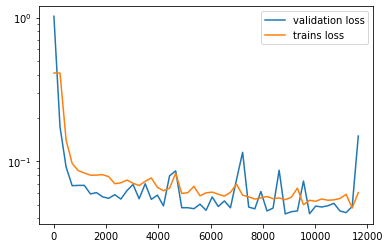

In [40]:
I_enc.checkpoint_load_system('_last')
plt.semilogy(I_enc.batch_id,I_enc.Loss_val,label='validation loss')
plt.semilogy(I_enc.batch_id,I_enc.Loss_train**0.5,label='trains loss')
plt.legend()

In [41]:
test_ss_enc = I_enc.apply_experiment(test,save_state=True)

NRMS simulation SS linear  14.67%


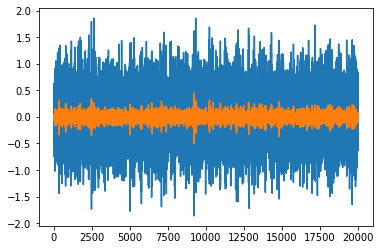

In [42]:
print(f'NRMS simulation SS linear  {test_ss_enc.NRMS(test):.2%}')

plt.plot(test.y[:])
plt.plot(test.y[:] - test_ss_enc.y[:])

# plt.subplot(1,2,1)
# plt.plot(test.y[:,0])
# plt.plot(test.y[:,0] - test_ss_enc.y[:,0])

# plt.subplot(1,2,2)
# plt.plot(test.y[:,1])
# plt.plot(test.y[:,1] - test_ss_enc.y[:,1]);

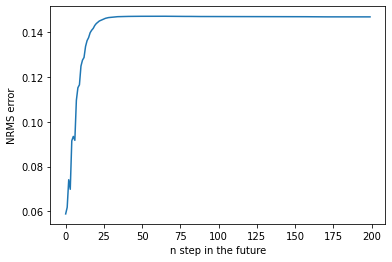

In [43]:
nsteperror = I_enc.n_step_error(test,nf=200) #return in NRMS units of fit_sys_ss_enc.norm
plt.plot(nsteperror)
plt.xlabel('n step in the future')
plt.ylabel('NRMS error')
plt.show()

In [39]:
I_enc.save_system("systems/ObserverUnbalancedDisk_dt01_nab_4_SNR_30_e50")

In [ ]:
#I_enc = deepSI.load_system("systems/OutputUnbalancedDisk_dt01_e300")

In [ ]:
# function that converts torch nn to casadi expression

from casadi import *

def CasADiHn(ss_enc, x):
    n_hidden_layers = ss_enc.h_n_hidden_layers

    params = {}
    for name, param in ss_enc.hn.named_parameters():
        params[name] = param.detach().numpy()
    params_list = list(params.values())

    temp_nn = x
    for i in range(n_hidden_layers):
        W_NL = params_list[2+i*2]
        b_NL = params_list[3+i*2]
        temp_nn = mtimes(W_NL, temp_nn)+b_NL
        temp_nn = tanh(temp_nn)
    W_NL = params_list[2+n_hidden_layers*2]
    b_NL = params_list[3+n_hidden_layers*2]
    nn_NL = mtimes(W_NL, temp_nn)+b_NL

    W_Lin = params_list[0]
    b_Lin = params_list[1]
    nn_Lin = mtimes(W_Lin,x) + b_Lin

    return nn_NL + nn_Lin

def CasADiFn(ss_enc, x, u):
    n_hidden_layers = ss_enc.f_n_hidden_layers

    params = {}
    for name, param in ss_enc.fn.named_parameters():
        params[name] = param.detach().numpy()
    params_list = list(params.values())
    
    xu = vertcat(x,u)

    temp_nn = xu
    for i in range(n_hidden_layers):
        W_NL = params_list[2+i*2]
        b_NL = params_list[3+i*2]
        temp_nn = mtimes(W_NL, temp_nn)+b_NL
        temp_nn = tanh(temp_nn)
    W_NL = params_list[2+n_hidden_layers*2]
    b_NL = params_list[3+n_hidden_layers*2]
    nn_NL = mtimes(W_NL, temp_nn)+b_NL

    W_Lin = params_list[0]
    b_Lin = params_list[1]
    nn_Lin = mtimes(W_Lin,xu) + b_Lin

    #f = Function('f', [x, u], [nn_NL + nn_Lin])
    return nn_NL + nn_Lin

In [ ]:
# function that checks whether torch nn and casadi function have the same behavior

import torch

def checkCasADiFn(ss_enc, casadi_fn):
    nu = 1000
    u = (torch.rand(nu,3)*2-1)*2
    ss_out = ss_enc.fn(u).detach().numpy()

    check = True
    for i in range(nu):
        xin = u[i,0:2].numpy().tolist()
        uin = u[i,2].item()
        cas_out = casadi_fn(xin, uin).elements()
        #equality_array = np.unique(np.round(np.array(cas_out) - ss_out[i,:], decimals=5) == 0.00000) #use np.isclose and np.all
        if np.allclose(np.array(cas_out), ss_out[i,:], rtol=1e-05, atol=1e-05) == False:
        #if equality_array.size != 1 or equality_array[0] == False:
            check = False

    return check

def checkCasADiHn(ss_enc, casadi_hn):
    nu = 1000
    u = (torch.rand(nu,2)*2-1)*2
    ss_out = ss_enc.hn(u).detach().numpy()

    check = True
    for i in range(nu):
        xin = u[i,:].numpy().tolist()
        cas_out = casadi_hn(xin).elements()
        #equality_array = np.unique(np.round(np.array(cas_out) - ss_out[i,:], decimals=5) == 0.00000) #use np.isclose and np.all
        if np.allclose(np.array(cas_out), ss_out[i,:], rtol=1e-05, atol=1e-05) == False:
        #if equality_array.size != 1 or equality_array[0] == False:
            check = False

    return check

In [ ]:
# declared sym variables
x = MX.sym("x",I_enc.nx,1)
nu = I_enc.nu if I_enc.nu is not None else 1
u = MX.sym("u",nu,1)

# convert torch nn to casadi function
rhs = CasADiFn(I_enc, x, u)
f = Function('f', [x, u], [rhs])

y_rhs = CasADiHn(I_enc, x)
h = Function('h', [x], [y_rhs])

# check if torch nn and casadi function have same behavior
check_f = checkCasADiFn(I_enc, f)
check_h = checkCasADiHn(I_enc, h)
check_f, check_h

In [ ]:
# apply correction to casadi function such that fc(0) = 0
correction_f = f([0,0], 0)
rhs_c = rhs - correction_f
correction_h = h([0,0])
y_rhs_c = y_rhs - correction_h
f_c = Function('f_c', [x, u], [rhs_c])
h_c = Function('h_c', [x], [y_rhs_c])
f_c([0,0], 0), h_c([0,0])

In [ ]:
# Box constraints
x_min = -10
x_max = 10
u_min = -4
u_max = 4

# Initial and final values
x0 = [0,0]
x_ref = [0.001, 1.0]
u_ref = 0

# Weight matrices for the cost function
#Q = 100
Q = np.matrix('1,0;0,100')
R = 1

# MPC parameters
dt = 0.1
Nc = 10
Nsim = 100
dlam = 0.01
stages = 1

In [ ]:
from my_rk4 import *
from lpv_int import *
from lpv_rk4 import *
import numpy as np
import time

opti = Opti()

# declare variables and parameters of states and inputs
n_states = np.shape(x)[0]
states = opti.variable(n_states,Nc+1)    
x_initial = opti.parameter(n_states,1)

n_controls = np.shape(u)[0]
controls = opti.variable(n_controls,Nc)

reference = opti.parameter(n_states,1)

# determine getA and getB functions
Jfx = Function("Jfx", [x, u], [jacobian(rhs_c,x)])
Jfu = Function("Jfu", [x, u], [jacobian(rhs_c,u)])
Jhx = Function("Jhx", [x, u], [jacobian(y_rhs_c,x)])
[A_sym, B_sym, C_sym] = lpv_int(x,n_states,u,n_controls,1,Jfx,Jfu,Jhx,dlam,stages)
get_A = Function("get_A",[x,u],[A_sym])
get_B = Function("get_B",[x,u],[B_sym])
get_C = Function("get_C",[x,u],[C_sym])

list_A = opti.parameter(Nc*n_states,n_states)
list_B = opti.parameter(Nc*n_states,n_controls)
list_C = opti.parameter(Nc*1,n_states)

# declare bounds of system
opti.subject_to(opti.bounded(x_min,states,x_max))
opti.subject_to(opti.bounded(u_min,controls,u_max))
opti.subject_to(states[:,0] == x_initial)

opts = {'print_time' : 0, 'ipopt': {'print_level': 0}}
opti.solver("ipopt",opts)

In [ ]:
objective = 0 #maybe add some soft bounds on the states and inputs
for i in np.arange(Nc):
    #opti.subject_to(states[:,i+1] == lpv_rk4(states[:,i],controls[:,i],\
    #    list_A[(n_states*i):(n_states*i+n_states),:],list_B[(n_states*i):(n_states*i+n_states),:],dt, correction)) # should this be changed to discrete time model
    opti.subject_to(states[:,i+1] == list_A[(n_states*i):(n_states*i+n_states),:]@states[:,i] \
        + list_B[(n_states*i):(n_states*i+n_states),:]@controls[:,i] + correction_f)
    objective = (objective + 
                    #mtimes(mtimes((states[:,i]-x_ref).T,Q),(states[:,i]-x_ref)) +
                    #mtimes(mtimes((controls[:,i]-u_ref).T,R),(controls[:,i]-u_ref)))
                    mtimes(mtimes((states[:,i]-reference).T,Q),(states[:,i]-reference)) +
                    mtimes(mtimes((controls[:,i]-u_ref).T,R),(controls[:,i]-u_ref)))

opti.minimize(objective)

In [ ]:
#reference_list = np.ones(Nsim+1)*1.0
reference_list = np.sin(np.arange(Nsim)*2*np.pi/128)*1
#reference_list = np.abs(reference_list)
#reference_list = np.hstack((np.ones(50)*1.0, np.ones(50)*-1.5, np.ones(50)*0.5, np.ones(50)*-2.5))
#plt.plot(reference_list)

In [ ]:
import random
x1_reference_list = np.array([])
Nsim_remaining = Nsim
while True:
    Nsim_steps = random.randint(10,15)
    Nsim_remaining = Nsim_remaining - Nsim_steps
    x1_reference_list = np.hstack((x1_reference_list, np.ones(Nsim_steps)*random.randint(-10,10)/10))

    if Nsim_remaining <= 0:
        x1_reference_list = x1_reference_list[:Nsim]
        break

In [ ]:
# normalize reference list
norm = I_enc.norm
reference_list_normalized = (reference_list - norm.y0[1])/norm.ystd[1]
x0_norm = (x0 - norm.y0)/norm.ystd

# logging list
t = np.zeros(Nsim)
t0 = 0
u_log = np.zeros([n_controls,Nsim])
x_log = np.zeros([n_states,Nsim+1])
comp_t_log = np.zeros(Nsim)
x_log[:,0] = x0
start = time.time()
lpv_counter = np.zeros(Nsim,int)

# set initial values for x
x = np.zeros([n_states,Nc+1])
u = np.zeros([n_controls,Nc]) # change this to u0 instead of 0 maybe
opti.set_initial(states, x)
opti.set_initial(controls, u)
opti.set_value(x_initial,x0_norm)

for mpciter in np.arange(Nsim):
    start_time_iter = time.time()

    # solve for u and x
    opti.set_value(reference,[0,reference_list_normalized[mpciter]])

    # MPC loop
    while True:
        # determine A,B
        for i in np.arange(Nc):
            opti.set_value(list_A[(n_states*i):(n_states*i+n_states),:],get_A(x[:,i],u[:,i]))
            opti.set_value(list_B[(n_states*i):(n_states*i+n_states),:],get_B(x[:,i],u[:,i]))
        
        # solve for u and x
        sol = opti.solve()
        u_old = u
        u = np.reshape(sol.value(controls),[n_controls,Nc])
        x = np.reshape(sol.value(states),[n_states,Nc+1]) # this relies on internal simulation in solution, this is x=Ax+Bu

        # simulate next step using rk4 over non correction casadi function
        #for i in np.arange(Nc):
        #    x[:,i+1] = np.ravel(my_rk4(x[:,i],u[:,i],f,dt),order='F')
        x = np.reshape(sol.value(states),[n_states,Nc+1]) # change this to nn maybe
        
        # set new x and u values into optimizer
        opti.set_initial(states, x)
        opti.set_initial(controls, u)

        lpv_counter[mpciter] += 1  

        # Stop MPC loop if max iteration reached or input converged
        if (lpv_counter[mpciter] >= 1) or (np.linalg.norm(u-u_old) < 1e-5):
            break

    print("MPC iteration: ", mpciter+1)
    print("LPV counter: ", lpv_counter[mpciter])

    t[mpciter] = t0
    t0 = t0 + dt
    try:
        x = x.full()
    except:
        x = x
    try:
        u = u.full()
    except:
        u = u
    
    # denormalize x and u
    x_denormalized = norm.ystd*x0_norm + norm.y0
    u_denormalized = norm.ustd*u[0,0] + norm.u0

    # make system step and normalize
    x_denormalized = system.f(x_denormalized, u_denormalized)
    x_measured = system.h(x_denormalized, u_denormalized)
    x0_norm = (x_measured - norm.y0)/norm.ystd

    x_log[:,mpciter+1] = x_measured
    u_log[:,mpciter] = u_denormalized
    
    x = horzcat(x[:,1:(Nc+1)],x[:,-1])
    x[:,0] = x0_norm
    u = horzcat(u[:,1:Nc],u[:,-1])
    opti.set_value(x_initial, x0_norm)
    opti.set_initial(states, x)
    opti.set_initial(controls, u)

    # finished mpc time measurement
    end_time_iter = time.time()
    comp_t_log[mpciter] = end_time_iter - start_time_iter

end = time.time()
runtime = end - start

In [ ]:
fig = plt.figure(figsize=[14.0, 3.0])

plt.subplot(1,3,1)
plt.plot(np.arange(Nsim+1)*dt, x_log[0,:], label='angular velocity')
plt.plot(np.arange(Nsim+1)*dt, np.ones(x_log.shape[1])*x_ref[0], label='reference')
plt.ylabel("velocity [m/s]") # not sure about the unit
plt.xlabel("time [s]")
plt.grid()
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(Nsim+1)*dt, x_log[1,:], label='angle')
#plt.plot(np.arange(Nsim+1)*dt, np.ones(x_log.shape[1])*x_ref[1], label='reference')
plt.plot(np.arange(Nsim+1)*dt, np.hstack((np.zeros(1),reference_list)), label='reference') # figure out what the correct hstack should be here
plt.ylabel("displacement [m]") # not sure about the unit
plt.xlabel("time [s]")
plt.grid()
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(Nsim)*dt, u_log[0,:], label='input')
plt.plot(np.arange(Nsim)*dt, np.ones(Nsim)*u_ref, label='reference')
plt.ylabel("input") # not sure about the unit
plt.xlabel("time [s]")
plt.grid()
plt.legend();